Initiliaze and prepare all models

In [1]:
# Load model from checkpoint
import torch
import yaml
from models.decoder import architectures

with open("models/decoder/sequential_decoder_length6_params.yaml") as file:
    params = yaml.safe_load(file)

#ckpt_file_path = "models/decoder/sequential_decoder_6.ckpt"
#model = architectures.LightningDecoderNet.load_from_checkpoint(ckpt_file_path, 
#                                                               inner_dims=params["inner_dims"], 
#                                                               seq_len=params["seq_len"], 
#                                                               learning_rate=params["learning_rate"])
#torch.save(model.state_dict(), "models/decoder/sequential_decoder_6.pth")

In [2]:
# ~~~~~~~~~~~~~~~~
# PyTorch Model

import torch
import yaml
from models.decoder import architectures

with open("models/decoder/sequential_decoder_params.yaml") as file:
    params = yaml.safe_load(file)

decoder = architectures.LightningDecoderNet(params["inner_dims"], params["seq_len"], params["learning_rate"])
decoder.load_state_dict(torch.load("models/decoder/sequential_decoder_length20.pth"))
decoder.eval();

# ~~~~~~~~~~~~~~~~
# ESM

# To Do

In [12]:
import matplotlib.pyplot as plt

def plot_gdm(data, ax=None, vmin=None, vmax=None):
    if ax is None:
        fig, ax = plt.subplots();
        
    ax.axis("off");
    return ax.imshow(data.squeeze().detach().numpy(), vmin=vmin, vmax=vmax)


def plot_dict(input_dict, figsize=[5,5], cbar_base_col=0):
    """ Plots the input of a dict. The dict should contain GDM data.
    
    Input:
    input_dict: ...
    figsize: ... (automatically in the future?)
    cbar_base_col: Which col should be used as baseline vmin and vmax of plt.imshow.
    """
    
    rows = len(next(iter(input_dict.values())))
    cols = len(input_dict)

    fig, axes = plt.subplots(rows, len(input_dict), constrained_layout=True, figsize=figsize)  
    
    # Loop over rows (amount of samples)
    for row in range(rows):
        vmin=None
        vmax=None

        vmin = input_dict[list(input_dict.keys())[cbar_base_col]][row].min()
        vmax = input_dict[list(input_dict.keys())[cbar_base_col]][row].max()   
        
        # Loop over cols (amount of models)
        for col, i in zip(input_dict, range(cols)):
            try:
                # Try for multiple rows
                plot_gdm(input_dict[col][row].squeeze(), axes[row][i], vmin=vmin, vmax=vmax);
                if row == 0:
                    axes[row][i].set_title(col)
        
            except:
                # otherwise only single row
                plot_gdm(input_dict[col][row].squeeze(), axes[i], vmin=vmin, vmax=vmax);
                if row == 0:
                    axes[i].set_title(col)
    
    return fig, axes

### Data & Metrics

Specify data

In [3]:
from torch.utils import data
from data.gdm_dataset import GasDataSet

dataset = GasDataSet("data/30x25/test.pt", seq_len=20)

In [8]:
# Load data

import pickle

X_path = "models/esm/X.pkl"
X_all = pickle.load(open(X_path, "rb"))

y_path = "models/esm/y.pkl"
y_all = pickle.load(open(y_path, "rb" ) )


# Load ESM predictions

from scipy.io import loadmat

y_esm_path = "models/esm/preds_bandwidth3_5_regDelay19.mat"
y_esm_all = loadmat(y_esm_path, verify_compressed_data_integrity=False)
y_esm_all = y_esm_all["export"]

Specify metrics

In [9]:
import gdm_metrics

rmse = {"decoder": 0,
        "esm": 0,
        }

kld = {"decoder": 0,
       "esm": 0,
       }

## Evaluation

In [ ]:
from tqdm import tqdm

rmse = {"decoder": 0,
        }

kld = {"decoder": 0,
       }


dataloader = iter(data.DataLoader(dataset, shuffle=False, drop_last=True))

for X, y in tqdm(dataloader):
    with torch.no_grad(): 
        y_decoder = decoder(X.squeeze(2))
        rmse["decoder"] += gdm_metrics.rmse(y_decoder, y)
        kld["decoder"] += gdm_metrics.kld(y_decoder, y)
            
print(f"########\n# RMSE #\n########")
for elem in rmse:
    print(f"{elem}: \t {rmse[elem]/len(X_all)}")
    
print(f"########\n# KL D #\n########")
for elem in kld:
    print(f"{elem}: \t {kld[elem]/len(X_all)}")

In [10]:
Bandwidth: 3.5
RegDelay: 19

In [11]:
import numpy as np
from tqdm import tqdm

rmse = {"decoder": 0,
        "esm": 0,
        }

kld = {"decoder": 0,
       "esm": 0,
       }

for i in tqdm(range(len(X_all))):
    X = X_all[i].unsqueeze(0)
    y = y_all[i].unsqueeze(0).unsqueeze(0)
    
    with torch.no_grad(): 
        y_decoder = decoder(X)
        rmse["decoder"] += gdm_metrics.rmse(y_decoder, y)
        kld["decoder"] += gdm_metrics.kld(y_decoder, y) 
    
    y_esm = torch.tensor(np.reshape(y_esm_all[i],[30,25], order="F"))
    y_esm = y_esm.unsqueeze(0).unsqueeze(0)
    rmse["esm"] += gdm_metrics.rmse(y_esm, y)
    kld["esm"] += gdm_metrics.kld(y_esm, y)
    
print(f"########\n# RMSE #\n########")
for elem in rmse:
    print(f"{elem}: \t {rmse[elem]/len(X_all)}")
    
print(f"########\n# KL D #\n########")
for elem in kld:
    print(f"{elem}: \t {kld[elem]/len(X_all)}")

100%|████████████████████████████████████| 30120/30120 [00:54<00:00, 550.89it/s]

########
# RMSE #
########
decoder: 	 0.07328736037015915
esm: 	 0.12451664358377457
########
# KL D #
########
decoder: 	 0.003549593733623624
esm: 	 0.013556098565459251


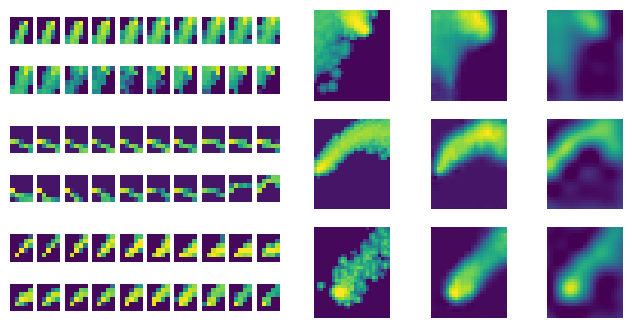

In [14]:
min_idx = 2137
max_idx = 11277

idxs = [2138,11277, 5278]

X_list = [X_all[idxs[0]].unsqueeze(0), 
          X_all[idxs[1]].unsqueeze(0), 
          X_all[idxs[2]].unsqueeze(0)]
y_list = [y_all[idxs[0]].unsqueeze(0).unsqueeze(0), 
          y_all[idxs[1]].unsqueeze(0).unsqueeze(0),
          y_all[idxs[2]].unsqueeze(0).unsqueeze(0)]
y_esm_list = [torch.tensor(np.reshape(y_esm_all[idxs[0]],[30,25], order="F")),
              torch.tensor(np.reshape(y_esm_all[idxs[1]],[30,25], order="F")),
              torch.tensor(np.reshape(y_esm_all[idxs[2]],[30,25], order="F")),
             ]


import matplotlib.pyplot as plt



fig = plt.figure(figsize=(8,4))
widths = [3, 1, 1, 1]

rows = len(X_list)

outer_grid = fig.add_gridspec(rows, 4, wspace=0.2, width_ratios=widths)


for row in range(rows):
    yhat = decoder(X_list[row])
    vmin = yhat.min().detach().numpy()
    vmax = yhat.max().detach().numpy()
    
    # Add the two axes to create the "broken" axes
    inner_grid = outer_grid[row, 0].subgridspec(ncols=10, nrows=2, wspace=0.2)
    ax1 = inner_grid.subplots()

    img_i = 0
    for xrow in ax1:
        for xcol in xrow:
            xcol.imshow(X_list[row].squeeze()[img_i], vmin=vmin, vmax=vmax)
            xcol.axis('off')
            img_i += 1

    # Truth
    ax2 = fig.add_subplot(outer_grid[row, 1])
    ax2.imshow(y_list[row].squeeze(), vmin=vmin, vmax=vmax)
    ax2.axis('off')

    # Decoder
    ax3 = fig.add_subplot(outer_grid[row, 2])
    ax3.imshow(decoder(X_list[row]).squeeze().detach().numpy(), vmin=vmin, vmax=vmax)
    ax3.axis('off')

    # ESM
    ax4 = fig.add_subplot(outer_grid[row, 3])
    ax4.imshow(y_esm_list[row], vmin=vmin, vmax=vmax)
    ax4.axis('off')

#plt.show()

import matplotlib as mpl

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : '5',
    #'text.usetex': True,
    'pgf.rcfonts': False,
})

mpl.pyplot.savefig("pgf/sequential-pred/sequential-pred.pgf", bbox_inches='tight', facecolor="w", pad_inches=0, dpi=500)

Bandwidth: 2.5
RegDelay: 15

In [8]:
import numpy as np
from tqdm import tqdm

rmse = {"decoder": 0,
        "esm": 0,
        }

kld = {"decoder": 0,
       "esm": 0,
       }

for i in tqdm(range(len(X_all))):
    X = X_all[i].unsqueeze(0)
    y = y_all[i].unsqueeze(0).unsqueeze(0)
    
    with torch.no_grad(): 
        y_decoder = decoder(X)
        rmse["decoder"] += gdm_metrics.rmse(y_decoder, y)
        kld["decoder"] += gdm_metrics.kld(y_decoder, y) 
    
    y_esm = torch.tensor(np.reshape(y_esm_all[i],[30,25], order="F"))
    y_esm = y_esm.unsqueeze(0).unsqueeze(0)
    rmse["esm"] += gdm_metrics.rmse(y_esm, y)
    kld["esm"] += gdm_metrics.kld(y_esm, y)
    
print(f"########\n# RMSE #\n########")
for elem in rmse:
    print(f"{elem}: \t {rmse[elem]/len(X_all)}")
    
print(f"########\n# KL D #\n########")
for elem in kld:
    print(f"{elem}: \t {kld[elem]/len(X_all)}")

100%|████████████████████████████████████| 30120/30120 [00:58<00:00, 519.17it/s]

########
# RMSE #
########
decoder: 	 0.07328736037015915
esm: 	 0.18055082857608795
########
# KL D #
########
decoder: 	 0.003549593733623624
esm: 	 0.12693370878696442


In [7]:
i = 1000

X = X_all[i].unsqueeze(0)
y = y_all[i].unsqueeze(0).unsqueeze(0)
y_esm = torch.tensor(np.reshape(y_esm_all[i],[30,25], order="F"))
y_esm = y_esm.unsqueeze(0).unsqueeze(0)

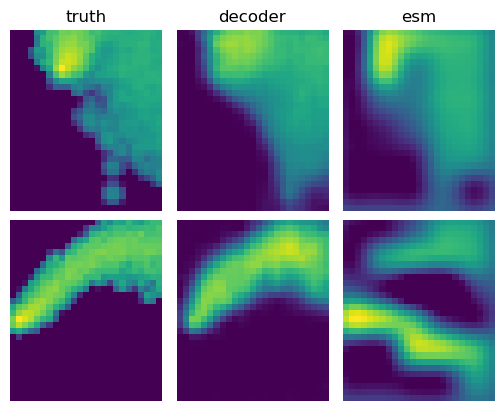

In [10]:
min_idx = 2137
max_idx = 11277

X_list = [X_all[min_idx].unsqueeze(0), X_all[max_idx].unsqueeze(0)]
y_list = [y_all[min_idx].unsqueeze(0).unsqueeze(0), y_all[max_idx].unsqueeze(0).unsqueeze(0)]
y_esm_list = [torch.tensor(np.reshape(y_esm_all[min_idx],[30,25], order="F")),
              torch.tensor(np.reshape(y_esm_all[max_idx],[30,25], order="F"))]
#plot_gdm(y_list[1])


data = {
        "truth": y_list,
        "decoder": [decoder(x) for x in X_list],
        "esm": y_esm_list,
        #"decoderdenoise": [model_denoise(x.squeeze(1)) for x in X_list],
        #"kdm": [kdm.calculate(x.squeeze()) for x in X_list],
        #"gmrf": [gmrf.calculate(x.squeeze()) for x in X_list],
        }

fig, axes = plot_dict(data, [5,4]);

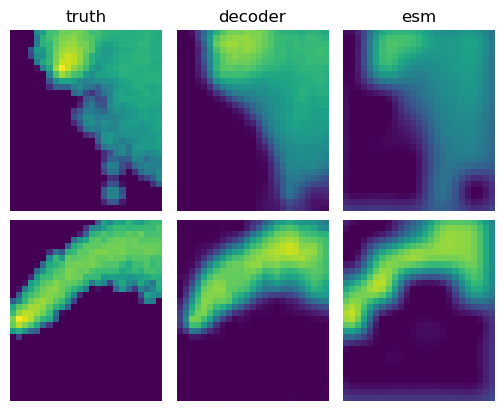

In [10]:
min_idx = 2137
max_idx = 11277

X_list = [X_all[min_idx].unsqueeze(0), X_all[max_idx].unsqueeze(0)]
y_list = [y_all[min_idx].unsqueeze(0).unsqueeze(0), y_all[max_idx].unsqueeze(0).unsqueeze(0)]
y_esm_list = [torch.tensor(np.reshape(y_esm_all[min_idx],[30,25], order="F")),
              torch.tensor(np.reshape(y_esm_all[max_idx],[30,25], order="F"))]
#plot_gdm(y_list[1])


data = {
        "truth": y_list,
        "decoder": [decoder(x) for x in X_list],
        "esm": y_esm_list,
        #"decoderdenoise": [model_denoise(x.squeeze(1)) for x in X_list],
        #"kdm": [kdm.calculate(x.squeeze()) for x in X_list],
        #"gmrf": [gmrf.calculate(x.squeeze()) for x in X_list],
        }

fig, axes = plot_dict(data, [5,4]);

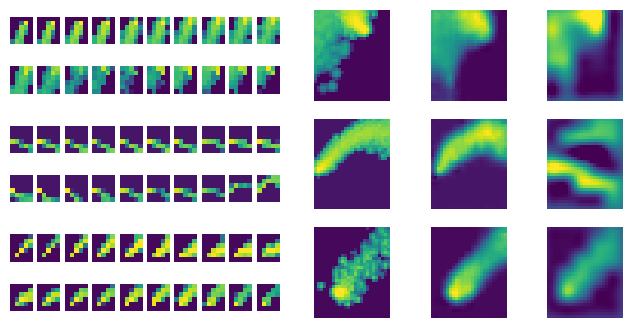

In [11]:
min_idx = 2137
max_idx = 11277

idxs = [2138,11277, 5278]

X_list = [X_all[idxs[0]].unsqueeze(0), 
          X_all[idxs[1]].unsqueeze(0), 
          X_all[idxs[2]].unsqueeze(0)]
y_list = [y_all[idxs[0]].unsqueeze(0).unsqueeze(0), 
          y_all[idxs[1]].unsqueeze(0).unsqueeze(0),
          y_all[idxs[2]].unsqueeze(0).unsqueeze(0)]
y_esm_list = [torch.tensor(np.reshape(y_esm_all[idxs[0]],[30,25], order="F")),
              torch.tensor(np.reshape(y_esm_all[idxs[1]],[30,25], order="F")),
              torch.tensor(np.reshape(y_esm_all[idxs[2]],[30,25], order="F")),
             ]


import matplotlib.pyplot as plt



fig = plt.figure(figsize=(8,4))
widths = [3, 1, 1, 1]

rows = len(X_list)

outer_grid = fig.add_gridspec(rows, 4, wspace=0.2, width_ratios=widths)


for row in range(rows):
    yhat = decoder(X_list[row])
    vmin = yhat.min().detach().numpy()
    vmax = yhat.max().detach().numpy()
    
    # Add the two axes to create the "broken" axes
    inner_grid = outer_grid[row, 0].subgridspec(ncols=10, nrows=2, wspace=0.2)
    ax1 = inner_grid.subplots()

    img_i = 0
    for xrow in ax1:
        for xcol in xrow:
            xcol.imshow(X_list[row].squeeze()[img_i], vmin=vmin, vmax=vmax)
            xcol.axis('off')
            img_i += 1

    # Truth
    ax2 = fig.add_subplot(outer_grid[row, 1])
    ax2.imshow(y_list[row].squeeze(), vmin=vmin, vmax=vmax)
    ax2.axis('off')

    # Decoder
    ax3 = fig.add_subplot(outer_grid[row, 2])
    ax3.imshow(decoder(X_list[row]).squeeze().detach().numpy(), vmin=vmin, vmax=vmax)
    ax3.axis('off')

    # ESM
    ax4 = fig.add_subplot(outer_grid[row, 3])
    ax4.imshow(y_esm_list[row], vmin=vmin, vmax=vmax)
    ax4.axis('off')

#plt.show()

import matplotlib as mpl

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : '5',
    #'text.usetex': True,
    'pgf.rcfonts': False,
})

mpl.pyplot.savefig("pgf/sequential-pred/sequential-pred.pgf", bbox_inches='tight', facecolor="w", pad_inches=0, dpi=500)

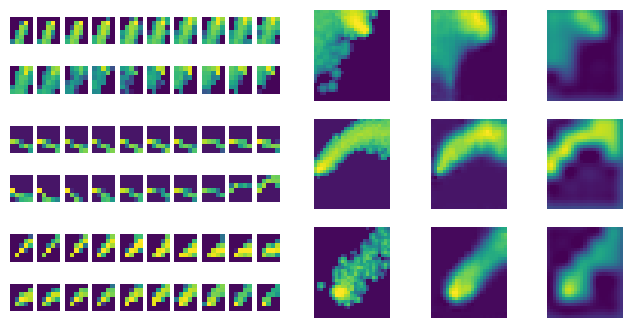

In [12]:
min_idx = 2137
max_idx = 11277

idxs = [2138,11277, 5278]

X_list = [X_all[idxs[0]].unsqueeze(0), 
          X_all[idxs[1]].unsqueeze(0), 
          X_all[idxs[2]].unsqueeze(0)]
y_list = [y_all[idxs[0]].unsqueeze(0).unsqueeze(0), 
          y_all[idxs[1]].unsqueeze(0).unsqueeze(0),
          y_all[idxs[2]].unsqueeze(0).unsqueeze(0)]
y_esm_list = [torch.tensor(np.reshape(y_esm_all[idxs[0]],[30,25], order="F")),
              torch.tensor(np.reshape(y_esm_all[idxs[1]],[30,25], order="F")),
              torch.tensor(np.reshape(y_esm_all[idxs[2]],[30,25], order="F")),
             ]


import matplotlib.pyplot as plt



fig = plt.figure(figsize=(8,4))
widths = [3, 1, 1, 1]

rows = len(X_list)

outer_grid = fig.add_gridspec(rows, 4, wspace=0.2, width_ratios=widths)


for row in range(rows):
    yhat = decoder(X_list[row])
    vmin = yhat.min().detach().numpy()
    vmax = yhat.max().detach().numpy()
    
    # Add the two axes to create the "broken" axes
    inner_grid = outer_grid[row, 0].subgridspec(ncols=10, nrows=2, wspace=0.2)
    ax1 = inner_grid.subplots()

    img_i = 0
    for xrow in ax1:
        for xcol in xrow:
            xcol.imshow(X_list[row].squeeze()[img_i], vmin=vmin, vmax=vmax)
            xcol.axis('off')
            img_i += 1

    # Truth
    ax2 = fig.add_subplot(outer_grid[row, 1])
    ax2.imshow(y_list[row].squeeze(), vmin=vmin, vmax=vmax)
    ax2.axis('off')

    # Decoder
    ax3 = fig.add_subplot(outer_grid[row, 2])
    ax3.imshow(decoder(X_list[row]).squeeze().detach().numpy(), vmin=vmin, vmax=vmax)
    ax3.axis('off')

    # ESM
    ax4 = fig.add_subplot(outer_grid[row, 3])
    ax4.imshow(y_esm_list[row], vmin=vmin, vmax=vmax)
    ax4.axis('off')

#plt.show()

import matplotlib as mpl

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : '5',
    #'text.usetex': True,
    'pgf.rcfonts': False,
})

mpl.pyplot.savefig("pgf/sequential-pred/sequential-pred.pgf", bbox_inches='tight', facecolor="w", pad_inches=0, dpi=500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


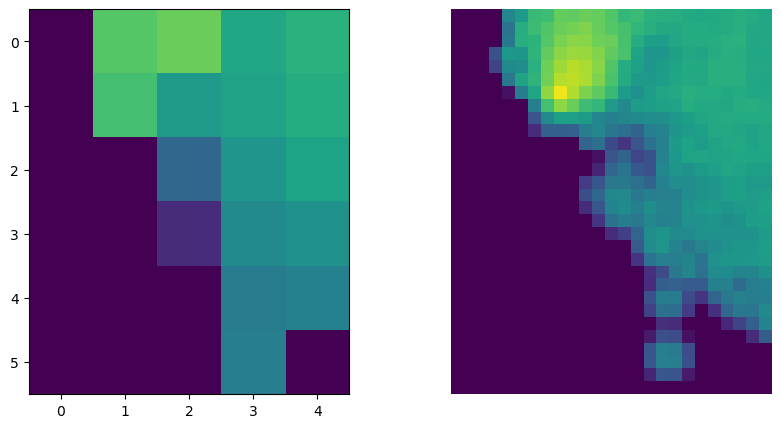

In [16]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 5x4 grid of subplots on the left
for i in range(20):
    print(i)
    ax1.imshow(tmp_X[i], vmin=0, vmax=1)
    plt.axis('off')

# Plot the 30x25 image on the right
ax2.imshow(tmp_y, vmin=0, vmax=1)
plt.axis('off')

# Display the plot
plt.show()

In [ ]:
import matplotlib as mpl

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : '5',
    #'text.usetex': True,
    'pgf.rcfonts': False,
})

mpl.pyplot.savefig("pgf/sequential-pred/sequential-pred.pgf", bbox_inches='tight', facecolor="w", pad_inches=0, dpi=500)

In [ ]:
from utils import plot_dict

X_list = [data_iter.next(), data_iter.next(), data_iter.next()]

data = {
        "input": X_list,
        "decoder": [model(x.squeeze(1)) for x in X_list],
        "decoderdenoise": [model_denoise(x.squeeze(1)) for x in X_list],
        "kdm": [kdm.calculate(x.squeeze()) for x in X_list],
        "gmrf": [gmrf.calculate(x.squeeze()) for x in X_list],
        }

fig, axes = plot_dict(data, [5,5]);